# Process bioclimatoc regions dataset 

And intersect with landcover to give us climate-landcover classes


In [1]:
import xarray as xr
import numpy as np
import distinctipy
import geopandas as gpd
import contextily as ctx
import matplotlib as mpl
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords, xr_rasterize

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Open bioclimatic regions

In [2]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/bioclimatic_regions.geojson')

# Dataset to reproject too and land-sea mask
rain = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/rain_5km_monthly_1981_2022.nc')['rain']
rain = rain.sel(time=slice('2000', '2010')).mean('time')

## Rasterize

In [3]:
bioclim = xr_rasterize(gdf, rain, attribute_col='bioclimatic_regions')
bioclim = round_coords(bioclim)
bioclim = bioclim.where(bioclim!=0)

## Plot

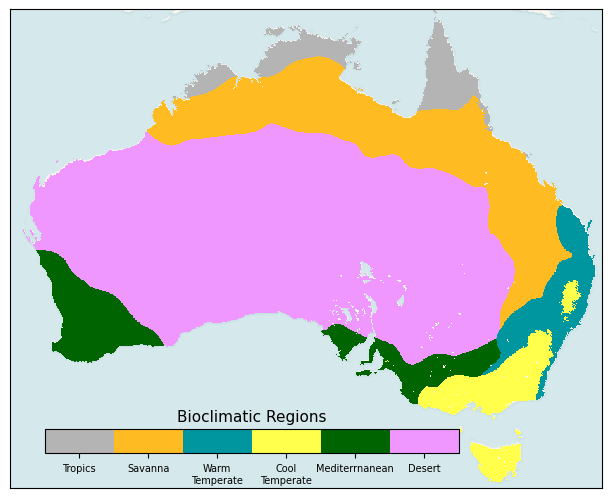

In [4]:
fig,ax = plt.subplots(1,1, figsize=(6,5), layout='constrained')

# categories =['Desert', 'Grassland', 'Temperate', 'Subtropical', 'Tropical', 'Equatorial']
categories =['Tropics', 'Savanna', 'Warm\nTemperate', 'Cool\nTemperate', 'Mediterrnanean', 'Desert']
colours = ['#b4b4b4',  '#ffbb22',   '#0096a0',     '#ffff4c',  '#006400'  ,   '#f096ff']

cmap = LinearSegmentedColormap.from_list("landcover_cmap", colours, N=len(colours))

im = (bioclim-1).plot(cmap=cmap, ax=ax, add_colorbar=False, add_labels=False)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

axins1 = inset_axes(ax,width="70%",height="5%",loc="lower left", borderpad=2.5)
cbar = fig.colorbar(im, cax=axins1, ticks=(np.arange(len(categories))+0.5)*(len(categories)-1)/(len(categories)), orientation='horizontal')
cbar.ax.set_title('Bioclimatic Regions', fontsize=11);
cbar.ax.set_xticklabels(categories, fontsize=7);

fig.savefig("/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/Bioclimatics_regions.png",
            bbox_inches='tight', dpi=300)

## Now intersect with landcover

In [5]:
lc = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/ESA_WorldCover_processed.nc')
lc = lc.where(lc<=3)

bioclim_adju = bioclim+50
bioclim_and_lc = bioclim_adju*lc #mulitply to get unique lc-climate classes

### Tidy up

In [6]:
# drop categories with < 1000 pixels
bioclim_and_lc = xr.where(bioclim_and_lc==102, np.nan, bioclim_and_lc)
bioclim_and_lc = xr.where(bioclim_and_lc==106, np.nan, bioclim_and_lc) 
bioclim_and_lc = xr.where(bioclim_and_lc==108, np.nan, bioclim_and_lc)

#make numbers sequential now
new = [57,58,59,60,61,62,63,64,65]
old = [104,110,112,153,156,159,162,165,168]

for r,k in {i:r for i,r in zip(old,new)}.items():
    bioclim_and_lc = xr.where(bioclim_and_lc.isin(r), k, bioclim_and_lc)

bioclim_and_lc = bioclim_and_lc-51 #make categories 0-12 instead of 51-64


In [7]:
clim_cat =['Tropics\n', 'Savanna\n', 'Warm\nTemperate\n', 'Cool\nTemperate\n', 'Mediterr-\nanean\n', 'Desert\n']

categories=[]
for k in clim_cat:
    categories.append(k+'-'+'Tree')
for k in clim_cat:
    categories.append(k+'-'+'Shrub')
for k in clim_cat:
    categories.append(k+'-'+'Grass')

categories.remove('Cool\nTemperate\n-Shrub')
categories.remove('Warm\nTemperate\n-Shrub')
categories.remove('Tropics\n-Shrub')

cat_dict = {i:c for i,c in zip(np.unique(bioclim_and_lc)[0:-1],categories)}

In [8]:
#number of pixels in each category
for i in np.unique(bioclim_and_lc)[0:-1]:
     print(int(i),':', np.sum(~np.isnan(bioclim_and_lc.where(bioclim_and_lc==i))).item())

0 : 9641
1 : 16845
2 : 5706
3 : 5989
4 : 2854
5 : 7908
6 : 1694
7 : 3013
8 : 37791
9 : 2359
10 : 33781
11 : 2234
12 : 1224
13 : 1766
14 : 101395


### PLot

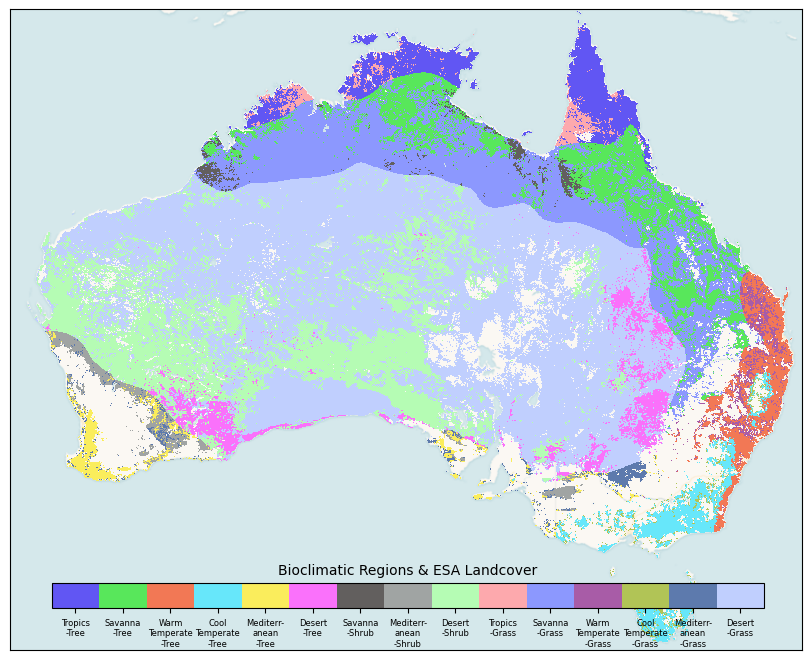

In [9]:
fig,ax = plt.subplots(1,1, figsize=(8,7), layout='constrained')

colours = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
cmap = LinearSegmentedColormap.from_list("cwc", colours, N=len(categories))

im = bioclim_and_lc.plot(cmap=cmap, ax=ax, add_colorbar=False, add_labels=False)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

axins1 = inset_axes(ax ,width="90%",height="4%",loc="lower left", borderpad=3)  
cbar = fig.colorbar(im, cax=axins1, ticks=(np.arange(len(categories))+0.5)*(len(categories)-1)/(len(categories)), orientation='horizontal')
cbar.ax.set_title('Bioclimatic Regions & ESA Landcover', fontsize=10);
cbar.ax.set_xticklabels(categories, fontsize=6);

fig.savefig("/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/Bioclim_and_landcover_classification.png",
            bbox_inches='tight', dpi=300)

## Export

In [10]:
# assign_crs(bioclim_and_lc, crs='EPSG:4326').odc.explore(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', cmap=cmap,
#             attr = 'Esri',
#             name = 'Esri Satellite')

In [11]:
bioclim_and_lc.to_netcdf('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/bioclim_and_landcover.nc')